In [1]:
use_multi_gpu = False 
import os

if  use_multi_gpu == True:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # The GPU id to use, usually either "0" or "1";
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1";
if  use_multi_gpu == False:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # The GPU id to use, usually either "0" or "1";
    os.environ["CUDA_VISIBLE_DEVICES"] = "4";
import tensorflow as tf
tf_version = tf.__version__
if int(str(tf.__version__)[0]) == 1:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    #config.log_device_placement = True  
    sess = tf.Session(config=config)
elif tf_version == '2.0.0':
    tf.compat.v1.disable_eager_execution()
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for gpus in physical_devices:
      tf.config.experimental.set_memory_growth(gpus, True)
      
elif int(str(tf.__version__)[0]) == 2:
    tf.compat.v1.disable_eager_execution()
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for gpus in physical_devices:
      tf.config.experimental.set_memory_growth(gpus, True)
      
from data_writers import show_results, draw_boxes, write_xml, yolotensor2xml, draw_on_image
from data_processors import adjust_pred, nms, get_boxes, extract_boxes
from tensorflow import keras
import shutil, os
import glob, time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math, random
from YOLO_DataGenerator import make_data_list, My_Custom_Generator, make_yolo_tensor, get_anchors
from evaluation import calculate_mAP, calculate_n_plot_mAP
from model import Darknet_19, yolo_exception, Darknet_19_mine
from losses import yolo_loss, yolo_loss2
from tqdm import tqdm, trange
from callbacks import PlotLearning, SGDRScheduler, CustomLearningRateScheduler, PredictionCallback
import tensorflow as tf
if int(str(tf.__version__)[0]) == 2:
   from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback, TensorBoard
   from tensorflow.keras.layers import Input, Conv2D, Dense, SeparableConv2D
   from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

if int(str(tf.__version__)[0]) == 1:
    from keras.models import Model
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback, TensorBoard
    from keras.layers import Input, Conv2D, Dense, SeparableConv2D
    from keras.optimizers import Adam, Nadam, SGD



________________________________________
Input Batch Shape    : (64, 416, 416, 3)
Label Labels Shape   : (64, 13, 13, 5, 25)
Output Batch Shape   : (64, 416, 416, 3)
Output Labels Shape  : (64, 13, 13, 5, 25)
True Box Buffer Shape: (64, 1, 1, 1, 50, 4)
________________________________________


Text(0.5, 1.0, 'Data_Gen_Test_img')

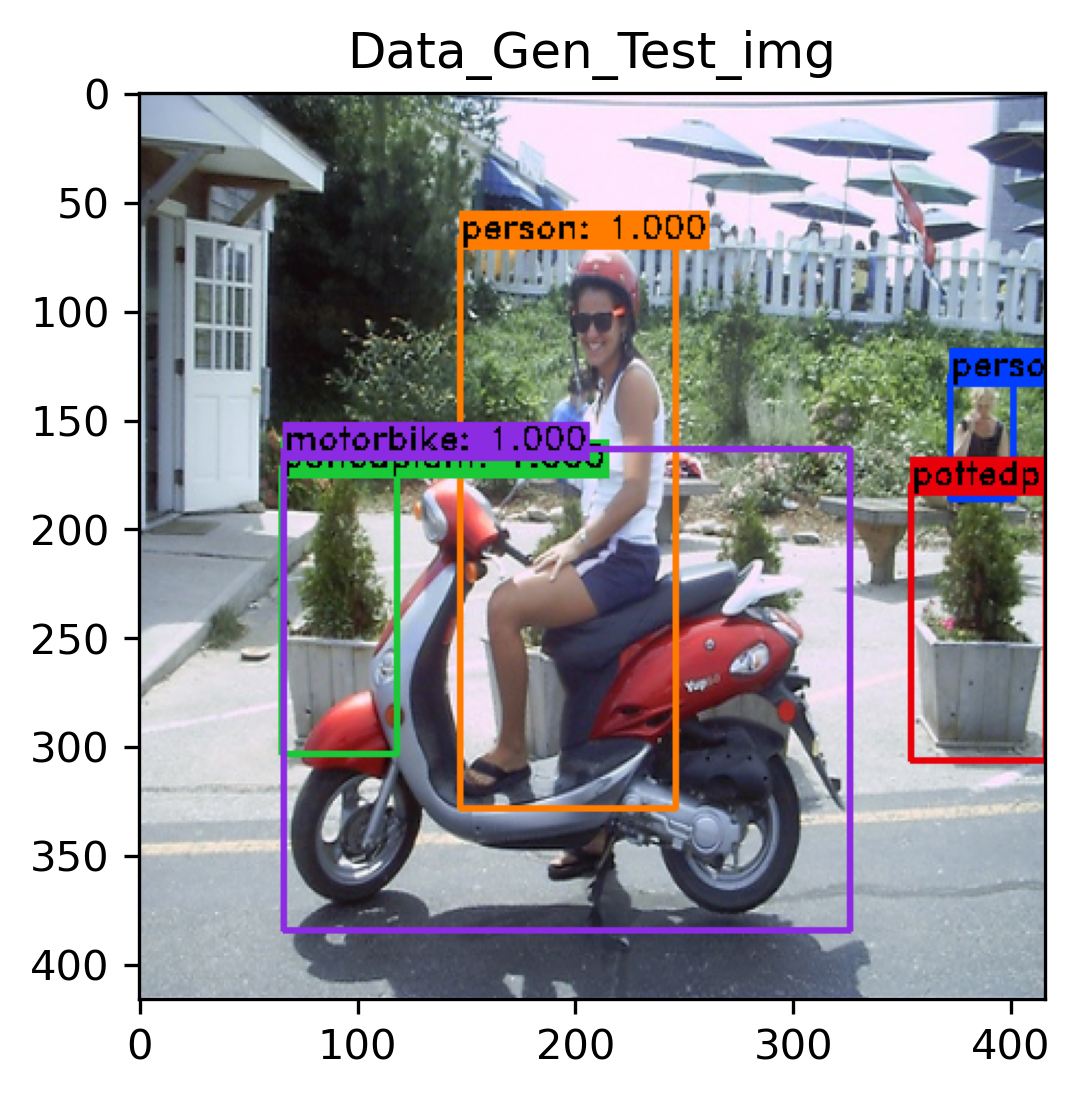

In [2]:
###########################################
#         Define Variable
###########################################
read_from_directory_train = '/home/user01/data_ssd/Talha/yolo_data/pascal_voc/train/'
read_from_directory_val = '/home/user01/data_ssd/Talha/yolo_data/pascal_voc/valid/'

true_box_buffer = 50
model_op_downsamples_by = 32 # 2^5 5 time downsampled
modelip_img_w = 416
modelip_img_h = 416
grid_h = int(modelip_img_h / model_op_downsamples_by)
grid_w = int(modelip_img_w / model_op_downsamples_by)
num_class = 20
batch_size = 64
input_ch = 3 
boxes_percell = 5
dropout_rate = 0.5
Epochs = 150
w_decay_value = 0.0005
initial_lr = 2e-5#0.0001
lr_decay = 0.95 #
drop_epoch = 30 #step decay
power = 0.9 # for polynomial decay
lr_schedule = 'K_decay'  # polynomial_decay  -or- step_decay -or- K_decay -or- SGDR_lr -or- yolo_decay

classes_name = []
with open(read_from_directory_train + '_classes.txt', 'r') as f:
        classes_name = classes_name + f.readlines()
for i in range(len(classes_name)):
    classes_name[i] = classes_name[i].strip()
    
###########################################
#         Start Data Generator
###########################################
X_train, Y_train = make_data_list(read_from_directory_train)
X_val, Y_val = make_data_list(read_from_directory_val)
anchors = get_anchors(read_from_directory_train)

train_data_gen = My_Custom_Generator(X_train, Y_train, batch_size, modelip_img_w, modelip_img_h,
                                     model_op_downsamples_by, anchors, num_class, true_box_buffer)
val_data_gen = My_Custom_Generator(X_val, Y_val, batch_size, modelip_img_w, modelip_img_h,
                                   model_op_downsamples_by, anchors, num_class, true_box_buffer)
#%
x_train, y_train = train_data_gen.__getitem__(27)
x_val, y_val = val_data_gen.__getitem__(2)
print('_'*40)
print('Input Batch Shape    :',x_train[0].shape)
print('Label Labels Shape   :', y_train.shape)
print('Output Batch Shape   :', x_val[0].shape)
print('Output Labels Shape  :', y_val.shape)
print('True Box Buffer Shape:', x_train[1].shape)
print('_'*40)
#%
# test images
op = draw_on_image(x_train[0][0, ...], y_train[0, ...], anchors, grid_h, grid_w, classes_name)
plt.imshow(op)
plt.title('Data_Gen_Test_img')

In [3]:
###########################################
#         Define Model
###########################################
grid_size = 13
input_img = Input((modelip_img_h, modelip_img_w,  input_ch), name='ip_image')
true_boxes  = Input(shape=(1, 1, 1, true_box_buffer , 4),  name = 'true_box_buffer')
model = Darknet_19(input_img, true_boxes, boxes_percell, num_class, dropout_rate, as_classifier = False, Alpha = 0.1)

for layer in model.layers:
        if isinstance(layer, Conv2D) or isinstance(layer, Dense):
            layer.kernel_regularizer = tf.keras.regularizers.l2(l=w_decay_value)
        elif isinstance(layer, SeparableConv2D):
            layer.depthwise_regularizer = tf.keras.regularizers.l2(l=w_decay_value/2)
            layer.pointwise_regularizer = tf.keras.regularizers.l2(l=w_decay_value/4)
        elif hasattr(layer, 'bias_regularizer') and layer.use_bias:
            layer.bias_regularizer =  tf.keras.regularizers.l2(l=w_decay_value)
            
model.summary()

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss = yolo_loss(true_boxes)) 
###########################################
#         Define Callbacks
###########################################
log_name = 'yolo_v2_pascal-{}'.format(int(time.time()))
plot_losses = PlotLearning()
if lr_schedule == 'SGDR_lr' :
    LR_schedule = SGDRScheduler(min_lr=1e-7,max_lr=initial_lr, steps_per_epoch=int(len(X_train) // batch_size),
                                lr_decay=lr_decay,cycle_length=20,mult_factor=2)
else:
    LR_schedule = CustomLearningRateScheduler(lr_schedule, initial_lr, lr_decay, Epochs, drop_epoch, power)
show_pred = PredictionCallback(X_val, Y_val, modelip_img_h, modelip_img_w, classes_name, grid_size, num_class, anchors)
callbacks = [
    EarlyStopping(patience=5, verbose=1), #Early Stopping if loss is not reduced since patience Epochs
    #ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00000001, verbose=1),  #Decay LR if loss is not reduced since 5 Epochs
    #LearningRateScheduler(schedule=yolo_decay, verbose=1), plot_losses
    LR_schedule, plot_losses, show_pred,#, DO_schedule, KR_schedule,
    TensorBoard(log_dir='logs/{}'.format(log_name), histogram_freq=0, write_graph=True, write_images=True,update_freq=100)
    #ModelCheckpoint('/home/user01/data_ssd/Talha/yolo_data/yolo_v2.h5', verbose=1, save_best_only=True, save_weights_only=True)# Save weights if val loss is improved
    #CSVLogger("pascal_vggt.csv", separator=',', append=True)
]  

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ip_image (InputLayer)           [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         ip_image[0][0]                   
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

In [4]:
# I already pretrained the model so just load weights 
model.load_weights('/home/user01/data_ssd/Talha/yolo_data/yolo_v2/pascal_voc.h5')

In [ ]:
model.fit(x=train_data_gen, steps_per_epoch = int(len(X_train) // batch_size), epochs = Epochs,initial_epoch=0,
          validation_data = val_data_gen, validation_steps = int(len(X_val) // batch_size), callbacks=callbacks)

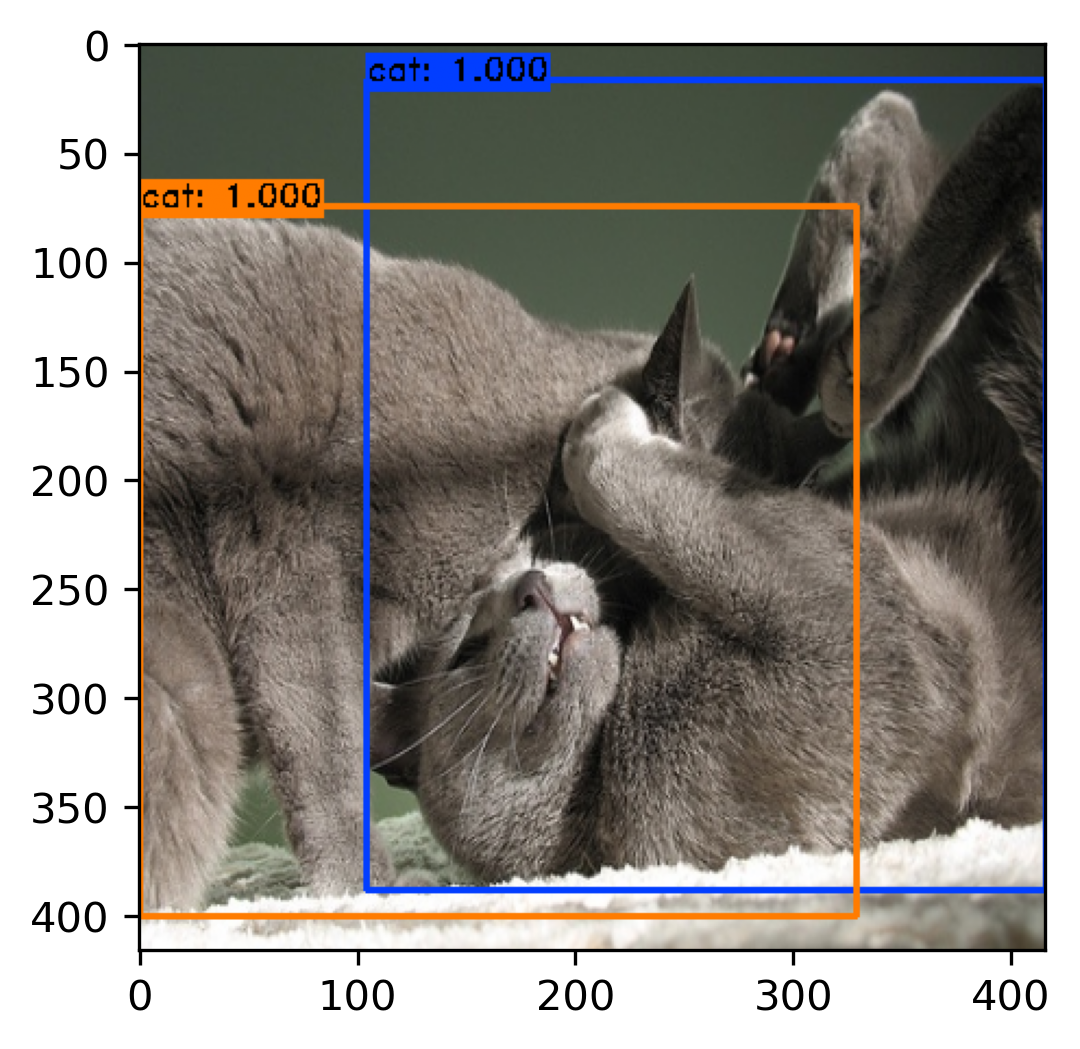

In [5]:
# check annontation files and read according index frm the list
i = np.random.randint(0,len(X_train))
orig_img, orig_op, _ = make_yolo_tensor(X_train[i], Y_train[i], modelip_img_w, modelip_img_h, model_op_downsamples_by, anchors, num_class, true_box_buffer)
op = draw_on_image(orig_img, orig_op, anchors, grid_h, grid_w, classes_name)
plt.imshow(orig_img)

In [ ]:
#################################################
#               Evaluation
#################################################
#model.load_weights('/home/user01/data_ssd/Talha/yolo_data/yolo_v2/yolo_v2_pretrain.h5')
model.evaluate(x=train_data_gen, steps = int(len(X_train) // batch_size))
model.evaluate(x=val_data_gen, steps = int(len(X_val) // batch_size))

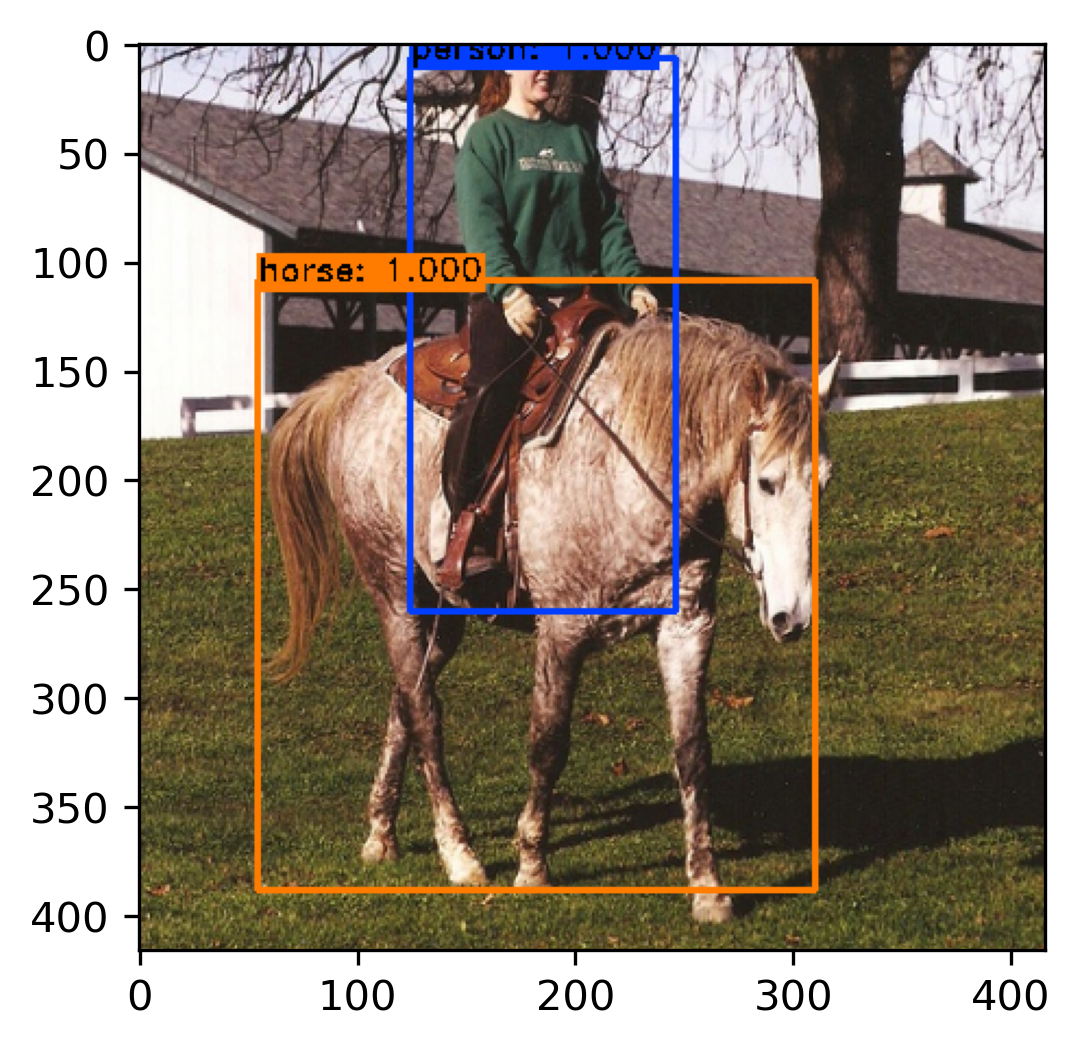

In [16]:
#################################################
#               Testing
#################################################
train_set = X_train
#index = np.random.randint(0,len(train_set))
#%
keep_boxes = 7
iou_thresh =  0.5
obj_thresh = 0.9

# Because for test iamges we won't have the GT boxes, handle the hack input
dummy_array = np.zeros((1,1,1,1,true_box_buffer,4))
img = cv2.imread(train_set[index])                    # Read image
img = cv2.resize(img, (modelip_img_w, modelip_img_h)) # Resize
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            # BGR -> RGB


pred = model.predict([img[np.newaxis, :,:,:] / 255, dummy_array])
pred = np.squeeze(pred)

Anchores = anchors.reshape(-1, 1)
pred_adj = adjust_pred(pred, Anchores)

b_boxes_scaled, detected_classes, class_scores = get_boxes(pred_adj, obj_thresh, modelip_img_w, modelip_img_h)
#b_boxes_scaled, detected_classes, class_scores = extract_boxes(pred_adj, obj_thresh, modelip_img_w, modelip_img_h)

nms_scores, nms_boxes, nms_classes_names = nms(b_boxes_scaled, detected_classes, class_scores,
                                               classes_name, iou_thresh, keep_boxes)

op = draw_boxes(img/255, nms_scores, nms_boxes, nms_classes_names, classes_name)
plt.imshow(op)

In [ ]:
#################################################
#               Calculate mAP
#################################################
# save the predicted xml files in this directory
op_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/yolo_pred/'
# deleting files in op_dir
filelist = [ f for f in os.listdir(op_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from Pred directory'):
    os.remove(os.path.join(op_dir, f))
gt_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/yolo_gt/'
# deleting files in gt_dir
filelist = [ f for f in os.listdir(gt_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from GT directory'):
    os.remove(os.path.join(gt_dir, f))

eval_set = X_train

#%
keep_boxes = 7
iou_thresh =  0.1
obj_thresh = 0.5

# Because for test iamges we won't have the GT boxes, handle the hack input
dummy_array = np.zeros((1,1,1,1,true_box_buffer,4))
for i in trange(len(eval_set), desc = 'Evaluating and saving to Pred directory'):
    img = cv2.imread(eval_set[i])                    # Read image
    img = cv2.resize(img, (modelip_img_w, modelip_img_h)) # Resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            # BGR -> RGB
    
    
    pred = model.predict([img[np.newaxis, :,:,:] / 255, dummy_array])
    pred = np.squeeze(pred)
    
    Anchores = anchors.reshape(-1, 1)
    pred_adj = adjust_pred(pred, Anchores)
    
    b_boxes_scaled, detected_classes, class_scores = get_boxes(pred_adj, obj_thresh, modelip_img_w, modelip_img_h)
    #b_boxes_scaled, detected_classes, class_scores = extract_boxes(pred_adj, obj_thresh, modelip_img_w, modelip_img_h)
    
    nms_scores, nms_boxes, nms_classes_names = nms(b_boxes_scaled, detected_classes, class_scores,
                                                   classes_name, iou_thresh, keep_boxes)
    
    
    write_xml(eval_set[i], nms_scores, nms_boxes, nms_classes_names, op_dir)


# read files from this dir and only copy the files which were predicted correctly
# by NETWORK       Annotations_XML    annotations_xml_processed    rice_xml   paparika_xml  bccd_xml
copy_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/annotations_xml_processed/'
# only copy the files on which network gave some predictions
# i.e. the files in op_dir 
filelist = [ f for f in os.listdir(op_dir)]
for f in tqdm(filelist, desc = 'Copying files to GT directory'):
    file = copy_dir + f
    shutil.copy(file, gt_dir)
    
print('Files in GT Directory:', len(glob.glob(os.path.join(gt_dir, '*.xml'))))
print('Files in Pred Directory:', len(glob.glob(os.path.join(op_dir, '*.xml'))))
#%

classes = classes_name
IoUThreshold = 0.3
calculate_mAP(gt_dir, op_dir, num_class, classes_name, IoUThreshold)